
<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Three: Training Models </h2>	

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import ray
# ray.init(include_webui=False, num_cpus=4)

In [2]:
def split(df, label='class'):
    """
    Given input df, splits the data into a training and test sets with given labels
    returns X_train, X_test, Y_train, Y_test 
    """
    train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df[label])
    X_train, Y_train = train.drop(columns=label, axis=1, inplace=False), train[label]
    X_test, Y_test = test.drop(columns=label, axis=1, inplace=False), test[label]
    return X_train, X_test, Y_train, Y_test

def accuracy(actual, pred):
    """
    Calculate the accuracy percentage of the predicted values
    """
    return accuracy_score(actual, pred)

##  Train models using all of the following methods below. Be sure to drop the actual image column, and the encoding	Take note of the differences in accuracy, and methods.


In [3]:
train_df_original = pd.read_pickle("./train_df.pkl")
train_df = train_df_original.drop(columns="filename", axis=1, inplace=False)
X_train, X_test, Y_train, Y_test = split(train_df)

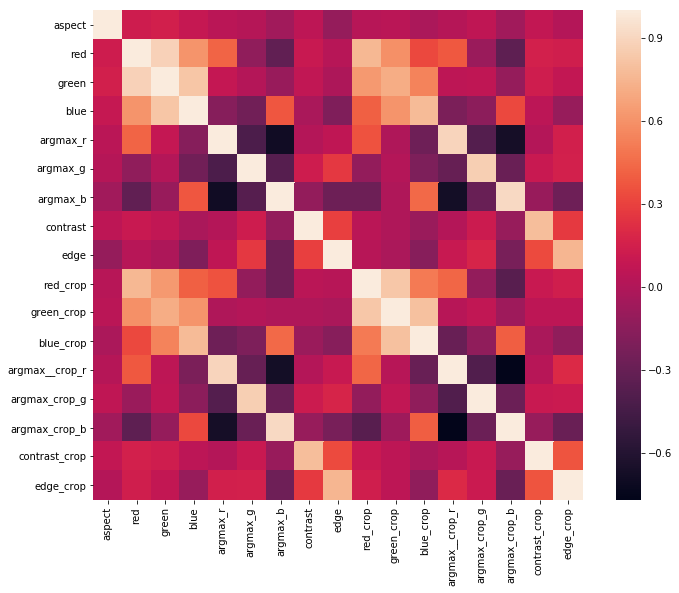

In [33]:
corr = X_train.corr()
import seaborn as sns
plt.figure(figsize=(12,9))
sns.heatmap(corr, square=True) #, cmap=colormap, annot=True, fmt=".2f")

### Logistic Regression

In [4]:
def train_test_logistic_regression(X_train, Y_train, X_valid, Y_valid, solver='liblinear'):
    """
    Given training and validation data, return the classification accuracy of a logistic regression 
    model. Defaults use l2 penalty and 'liblinear' solver.
    """
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(solver = solver,).fit(X_train, Y_train)
    predictions = clf.predict(X_valid)
    return accuracy_score(predictions, Y_valid)

# train_test_logistic_regression(X_train, Y_train, X_valid, Y_valid)

def train_test_logistic_regression_cv(X_train, Y_train, solver='liblinear', C=1.0, k=5):
    """
    Given training data, perform stratified k-fold cross-validation and return the validation scores in a dictionary
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import cross_validate
    
    logistic = LogisticRegression(solver = solver, C=C)
    cv_results = cross_validate(logistic, X=X_train, y=Y_train, cv=k, return_train_score=False, return_estimator=True)
    
    max_ind = np.where(cv_results["test_score"] == max(cv_results["test_score"]))
    max_estimator = cv_results["estimator"][max_ind[0][0]]
    return np.mean(cv_results["test_score"]), np.std(cv_results["test_score"]), max_estimator

@ray.remote(num_return_vals=3)
def train_test_logistic_regression_cv_remote(X_train, Y_train, solver='liblinear', C=1.0, k=5):
    """
    Given training data, use ray parallelization to perform stratified k-fold cross-validation 
    on logistic regression classifier and return the validation accuracy scores in a dictionary
    """
    return train_test_logistic_regression_cv(X_train, Y_train, solver, C, k)

In [23]:
means_list = []
std_list = []
estimator_list = []
penalty_list = []
folds_list = []

for penalty in [0.5, 1.0, 2.0, 10.0, 50.0]: # 
    for k in [3, 5, 10]: # 
        mean_acc, std_acc, estimator = train_test_logistic_regression_cv_remote.remote(X_train, Y_train, solver='liblinear', C=penalty, k=k)
        means_list.append(mean_acc)
        std_list.append(std_acc)
        estimator_list.append(estimator)
        penalty_list.append(penalty)
        folds_list.append(k)
        
mean_list = ray.get(means_list)
std_list = ray.get(std_list)
estimator_list = ray.get(estimator_list)

# convert the above results into a dataframe sorted by mean_validation_accuracy and display top 5 best models and params
optimal = np.column_stack((mean_list, std_list, penalty_list, folds_list, estimator_list))
optimal = pd.DataFrame(sorted(optimal, key=lambda x:x[0], reverse=True), 
                       columns=["Mean_Val_Acc", "Std_Val_Acc", "Regularization_Penalty", "Num_Folds", "Best_Estimator"])
optimal.head()

,Mean_Val_Acc,Std_Val_Acc,Regularization_Penalty,Num_Folds,Best_Estimator
0,0.410127,0.022898,50.0,5,"LogisticRegression(C=50.0, class_weight=None, ..."
1,0.402614,0.026245,10.0,5,"LogisticRegression(C=10.0, class_weight=None, ..."
2,0.400625,0.032264,10.0,10,"LogisticRegression(C=10.0, class_weight=None, ..."
3,0.394885,0.036816,50.0,10,"LogisticRegression(C=50.0, class_weight=None, ..."
4,0.392560,0.011722,50.0,3,"LogisticRegression(C=50.0, class_weight=None, ..."


In [24]:
predictions = optimal.loc[0,"Best_Estimator"].predict(X_test)
accuracy(Y_test, predictions)

0.4053156146179402

### K-nearest Neighbors

In [18]:
def train_test_knn(X_train, Y_train, X_val, Y_val, nearest_neighbor=10):
    """
    Given training and validation data, return the classification accuracy of a K-Nearest-Neighbours 
    model. Defaults use 10 neighbours.
    """
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(n_neighbors = nearest_neighbor).fit(X_train, Y_train)
    predictions = clf.predict(X_valid)
    return accuracy(predictions, Y_valid)

# using parallelization to speed up the training
@ray.remote
def train_test_knn_remote(X_train, Y_train, X_val, Y_val, nearest_neighbors=10):
    return train_test_knn(X_train, Y_train, X_val, Y_val, nearest_neighbors)

def train_test_knn_cv(X_train, Y_train, nearest_neighbor=10, k=5):
    from sklearn.model_selection import cross_validate
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors = nearest_neighbor)
    
    cv_results = cross_validate(knn, X=X_train, y=Y_train, cv=k, return_train_score=False, return_estimator=True)
    
    max_ind = np.where(cv_results["test_score"] == max(cv_results["test_score"]))
    max_estimator = cv_results["estimator"][max_ind[0][0]]
    return np.mean(cv_results["test_score"]), np.std(cv_results["test_score"]), max_estimator


@ray.remote(num_return_vals=3)
def train_test_knn_cv_remote(X_train, Y_train, nearest_neighbor=10, k=5):
    """
    Given training data, use ray parallelization to perform stratified k-fold cross-validation 
    on k-Nearest Neighbor classifier and return the validation accuracy scores in a dictionary
    """
    return train_test_knn_cv(X_train, Y_train, nearest_neighbor, k)

# train_test_knn_cv(X_train, Y_train, nearest_neighbor=10, k=5)

In [25]:
n_list = []
means_list = []
std_list = []
estimator_list = []
folds_list = []

for k in [3, 5, 10, 15]:
    for nearest_neighbor in range(2,25,2):   # tuning num of nearest neghbour classifiers 
        mean_acc, std_acc, estimator = train_test_knn_cv_remote.remote(X_train, Y_train, nearest_neighbor, k=k)
        means_list.append(mean_acc)
        std_list.append(std_acc)
        estimator_list.append(estimator)
        n_list.append(nearest_neighbor)
        folds_list.append(k)

mean_list = ray.get(means_list)
std_list = ray.get(std_list)
estimator_list = ray.get(estimator_list)

# convert the above results into a dataframe sorted by mean_validation_accuracy and display top 5 best models and params
optimal = np.column_stack((mean_list, std_list, n_list, folds_list,  estimator_list))
optimal = pd.DataFrame(sorted(optimal, key=lambda x:x[0], reverse=True), 
                       columns=["Mean_Val_Acc", "Std_Val_Acc", "Num_nearest_neighbor", "Num_Folds", "Best_Estimator"])
optimal.head()

,Mean_Val_Acc,Std_Val_Acc,Num_nearest_neighbor,Num_Folds,Best_Estimator
0,0.298723,0.040594,18,10,"KNeighborsClassifier(algorithm='auto', leaf_si..."
1,0.292592,0.040900,16,10,"KNeighborsClassifier(algorithm='auto', leaf_si..."
2,0.291523,0.012055,18,3,"KNeighborsClassifier(algorithm='auto', leaf_si..."
3,0.287679,0.037791,22,10,"KNeighborsClassifier(algorithm='auto', leaf_si..."
4,0.287579,0.053569,22,15,"KNeighborsClassifier(algorithm='auto', leaf_si..."


In [26]:
predictions = optimal.loc[0,"Best_Estimator"].predict(X_test)
accuracy(Y_test, predictions)

0.31561461794019935

### Random Forest

In [4]:
def train_test_random_forest(X_train, Y_train, X_valid, Y_valid, num_classifiers=100, depth=5):
    """
    Given training and validation data, return the classification accuracy of a random forest 
    model. Defaults use num_classifiers=100 and depth=5.
    """
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=num_classifiers, max_depth=depth).fit(X_train, Y_train)
    predictions = clf.predict(X_valid)
    return accuracy_score(Y_valid, predictions)

# using parallelization to speed up the training
@ray.remote
def train_test_random_forest_remote(X_train, Y_train, X_valid, Y_valid, num_classifiers=100, depth=5):
    return train_test_random_forest(X_train, Y_train, X_valid, Y_valid, num_classifiers, depth)


def train_test_random_forest_cv(X_train, Y_train, num_classifiers=100, depth=5, k=5):
    from sklearn.model_selection import cross_validate
    from sklearn.ensemble import RandomForestClassifier
    rand_forest = RandomForestClassifier(n_estimators=num_classifiers, max_depth=depth) # .fit(X_train, Y_train)
    cv_results = cross_validate(rand_forest, X=X_train, y=Y_train, cv=k, return_train_score=False, return_estimator=True)
    
    max_ind = np.where(cv_results["test_score"] == max(cv_results["test_score"]))
    max_estimator = cv_results["estimator"][max_ind[0][0]]
    return np.mean(cv_results["test_score"]), np.std(cv_results["test_score"]), max_estimator

@ray.remote(num_return_vals=3)
def train_test_random_forest_cv_remote(X_train, Y_train, num_classifiers=100, depth=5, k=5):
    """
    Given training data, use ray parallelization to perform stratified k-fold cross-validation 
    on Random Forest classifier and return the validation accuracy scores in a dictionary
    """
    return train_test_random_forest_cv(X_train, Y_train, num_classifiers, depth, k)

# ray.get(train_test_random_forest_cv_remote.remote(X_train, Y_train, num_classifiers=60, depth=10, k=5))

In [8]:
n_list = []
d_list = []
means_list = []
std_list = []
estimator_list = []
folds_list = []

for k in [5]:      # tuning number of folds , 3, 10, 15
    for n in range(500, 349, -50):   # tuning the number of classifiers
        for d in range(3, 6):      # tuning the depth of each classifier
            mean_acc, std_acc, estimator  = train_test_random_forest_cv_remote.remote(X_train, Y_train, num_classifiers=n, depth=d, k=k)
            means_list.append(mean_acc)
            std_list.append(std_acc)
            estimator_list.append(estimator)
            n_list.append(n)
            d_list.append(d)
            folds_list.append(k)
        
mean_list = ray.get(means_list)
std_list = ray.get(std_list)
estimator_list = ray.get(estimator_list)

# convert the above results into a dataframe sorted by mean_validation_accuracy and display top 5 best models and params
optimal = np.column_stack((mean_list, std_list, n_list, d_list, folds_list, estimator_list))
optimal = pd.DataFrame(sorted(optimal, key=lambda x:x[0], reverse=True), 
                       columns=["Mean_Val_Acc", "Std_Val_Acc", "Num_classifiers", "Depth_per_classifier", "Num_Folds", "Best_Estimator"])
optimal.head()

,Mean_Val_Acc,Std_Val_Acc,Num_classifiers,Depth_per_classifier,Num_Folds,Best_Estimator
0,0.362706,0.015601,450,5,5,"(DecisionTreeClassifier(class_weight=None, cri..."
1,0.358622,0.014503,350,5,5,"(DecisionTreeClassifier(class_weight=None, cri..."
2,0.358575,0.013926,500,5,5,"(DecisionTreeClassifier(class_weight=None, cri..."
3,0.351923,0.012889,400,5,5,"(DecisionTreeClassifier(class_weight=None, cri..."
4,0.326223,0.018270,500,4,5,"(DecisionTreeClassifier(class_weight=None, cri..."


In [9]:
predictions = optimal.loc[0,"Best_Estimator"].predict(X_test)
accuracy(Y_test, predictions)

0.3588039867109635

### Support Vector Machine

In [10]:
def train_test_svm(X_train, Y_train, X_valid, Y_valid, C=10):
    """
    Given training and validation data, return the classification accuracy of a support vector 
    machine model. Defaults use penalty param C=10 for training.
    """
    from sklearn.svm import LinearSVC
    clf = LinearSVC(C = 10).fit(X_train, Y_train)
    predictions = clf.predict(X_valid)
    return accuracy_score(Y_valid, predictions)

# using parallelization to speed up the training
@ray.remote
def train_test_svm_remote(X_train, Y_train, X_valid, Y_valid, C=10):
    return train_test_svm(X_train, Y_train, X_valid, Y_valid, C)

def train_test_svm_cv(X_train, Y_train, C=10, k=5):
    from sklearn.model_selection import cross_validate    
    from sklearn.svm import LinearSVC
    svm = LinearSVC(C = C)
    cv_results = cross_validate(svm, X=X_train, y=Y_train, cv=k, return_train_score=False, return_estimator=True)
    
    max_ind = np.where(cv_results["test_score"] == max(cv_results["test_score"]))
    max_estimator = cv_results["estimator"][max_ind[0][0]]
    return np.mean(cv_results["test_score"]), np.std(cv_results["test_score"]), max_estimator

@ray.remote(num_return_vals=3)
def train_test_svm_cv_remote(X_train, Y_train, C=10, k=5):
    """
    Given training data, use ray parallelization to perform stratified k-fold cross-validation 
    on Support Vector Machine classifier and return the validation accuracy scores in a dictionary
    """
    return train_test_svm_cv(X_train, Y_train, C, k)


In [19]:
penalty_list = []
means_list = []
std_list = []
estimator_list = []
folds_list = []

for k in [5]:  # tuning number of folds 3, 5, 10, 15
    for c in range(1,101,5):    # tuning penalty param c
        mean_acc, std_acc, estimator = train_test_svm_cv_remote.remote(X_train, Y_train, C=c, k=k)
        means_list.append(mean_acc)
        std_list.append(std_acc)
        estimator_list.append(estimator)
        penalty_list.append(c)
        folds_list.append(k)
    
mean_list = ray.get(means_list)
std_list = ray.get(std_list)
estimator_list = ray.get(estimator_list)


# Display top 5 results along with params sorted on accuracy
optimal = np.column_stack((mean_list, std_list, penalty_list, folds_list, estimator_list))
optimal = pd.DataFrame(sorted(optimal, key=lambda x:x[0], reverse=True), 
                       columns=["Mean_Val_Acc", "Std_Val_Acc", "Regularization_penalty", "Num_Folds", "Best_Estimator"])
optimal.head()

,Mean_Val_Acc,Std_Val_Acc,Regularization_penalty,Num_Folds,Best_Estimator
0,0.188200,0.038128,61,5,"LinearSVC(C=61, class_weight=None, dual=True, ..."
1,0.184905,0.086496,56,5,"LinearSVC(C=56, class_weight=None, dual=True, ..."
2,0.183687,0.089390,31,5,"LinearSVC(C=31, class_weight=None, dual=True, ..."
3,0.169497,0.064307,6,5,"LinearSVC(C=6, class_weight=None, dual=True, f..."
4,0.164938,0.067196,11,5,"LinearSVC(C=11, class_weight=None, dual=True, ..."


In [20]:
predictions = optimal.loc[0,"Best_Estimator"].predict(X_test)
accuracy(Y_test, predictions)

0.2425249169435216